In [23]:
import numpy as np
import math 
import queue
import os
import neat
import visualize
import random
import matplotlib.pyplot as plt
import pickle

%load_ext autoreload
%autoreload 2

import GameManager
from GameManager import *

import Neat_AI
from Neat_AI import *

import AI_modules
from AI_modules import *

import my_reporters
from my_reporters import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
local_dir = os.path.abspath('')
config_path = os.path.join(local_dir, 'config-feedforward')

In [25]:
dimensions = (8,8)
units_per_side = 5
manager = map_manager(dimensions)

# for i in range(games_run):
#also resets map
manager.setup_layouts_rand(1, units_per_side)
manager.apply_map_layout(0)
print(manager)

while (manager.game_joever() == -1 and manager.turn_count < 8): #Turn Count limit may have to be modified
    for unit in manager.Teams[manager.curr_team].live_units:
        win_move = (0, 0)
        if manager.curr_team == 0:
            win_move = neat_ai(manager, unit, best_networks[1])
        elif manager.curr_team == 1:
            win_move = script_ai(manager, unit)
            #win_move = neat_ai(manager, unit, win_net)
        manager.move_unit(unit, win_move)
    #print(manager)
    manager.Turn()

[ ][0][ ][ ][ ][ ][1][ ]
[ ][ ][ ][ ][ ][ ][ ][ ]
[ ][0][ ][ ][ ][ ][1][ ]
[ ][ ][ ][ ][ ][ ][ ][ ]
[ ][0][ ][ ][ ][ ][ ][1]
[ ][0][ ][ ][ ][ ][ ][1]
[ ][ ][ ][ ][ ][ ][ ][ ]
[0][ ][ ][ ][ ][ ][1][ ]



In [9]:
dimensions = (8,8)
units_per_side = 5
manager = map_manager(dimensions)

# for i in range(games_run):
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_path)
script_performance(manager, win_net, config)

NameError: name 'win_net' is not defined

In [29]:
print(best_networks)
best_networks_copy = copy.deepcopy(best_networks)

[<neat.nn.feed_forward.FeedForwardNetwork object at 0x000001FBF2F0E040>, <neat.nn.feed_forward.FeedForwardNetwork object at 0x000001FBF4EC8760>, <neat.nn.feed_forward.FeedForwardNetwork object at 0x000001FBF3276F40>]



 ****** Running generation 0 ****** 

Population's average fitness: 0.00067 stdev: 0.00485
Best fitness: 0.04000 - size: (2, 61) - species 1 - id 6
Best genome Winrate vs. script : 0.07
Best genome Winrate vs. 1 : 0.0
Best genome Winrate vs. 2 : 0.02
Best genome Winrate vs. 3 : 0.0
Average adjusted fitness: 0.000
Mean genetic distance 2.433, standard deviation 0.632
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0    89      0.0    0.001     0
     2    0    61      0.0    0.000     0
Total extinctions: 0
Generation time: 62.841 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.00373 stdev: 0.02404
Best fitness: 0.22000 - size: (1, 30) - species 2 - id 206
Best genome Winrate vs. script : 0.36
Best genome Winrate vs. 1 : 0.0
Best genome Winrate vs. 2 : 0.2
Best genome Winrate vs. 3 : 0.0
Average adjusted fitness: 0.004
Mean genetic distance 2.360, standard deviation 0.539
Po

Population's average fitness: 0.17333 stdev: 0.13639
Best fitness: 0.50000 - size: (2, 28) - species 2 - id 1294
Best genome Winrate vs. script : 0.56
Best genome Winrate vs. 1 : 0.23
Best genome Winrate vs. 2 : 0.29
Best genome Winrate vs. 3 : 0.09
Average adjusted fitness: 0.175
Mean genetic distance 1.490, standard deviation 0.286
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   13    70      0.5    0.154     0
     2   13    80      0.5    0.195     5
Total extinctions: 0
Generation time: 52.394 sec (51.933 average)

 ****** Running generation 14 ****** 

Population's average fitness: 0.17800 stdev: 0.14938
Best fitness: 0.48000 - size: (3, 21) - species 1 - id 2065
Best genome Winrate vs. script : 0.57
Best genome Winrate vs. 1 : 0.12
Best genome Winrate vs. 2 : 0.3
Best genome Winrate vs. 3 : 0.05
Average adjusted fitness: 0.177
Mean genetic distance 1.375, standard deviation 0.410
Population of 1

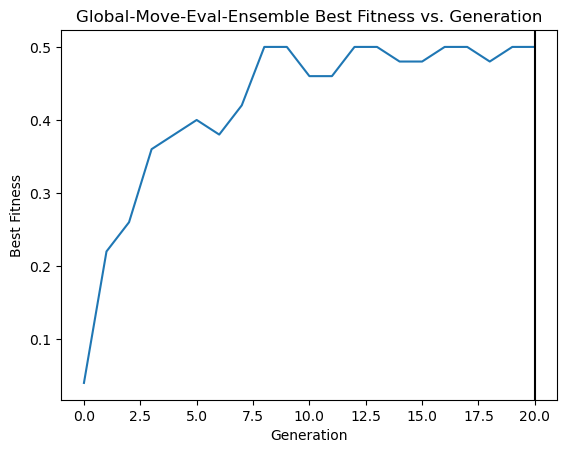

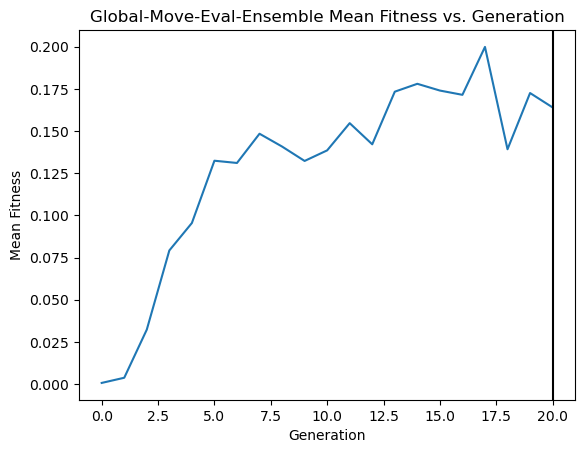

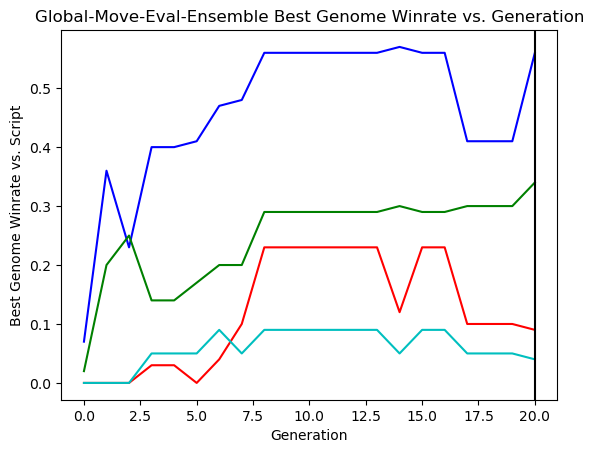

Average adjusted fitness: 0.165
Mean genetic distance 1.899, standard deviation 0.478
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   20    30      0.4    0.166     6
     2   20   120      0.5    0.163    12
Total extinctions: 0
Generation time: 56.615 sec (52.673 average)

 ****** Running generation 21 ****** 

Population's average fitness: 0.13493 stdev: 0.13093
Best fitness: 0.46000 - size: (2, 28) - species 1 - id 1294
Best genome Winrate vs. script : 0.56
Best genome Winrate vs. 1 : 0.23
Best genome Winrate vs. 2 : 0.29
Best genome Winrate vs. 3 : 0.09
Average adjusted fitness: 0.129
Mean genetic distance 1.816, standard deviation 0.468
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   21    35      0.5    0.118     7
     2   21   115      0.4    0.139    13
Total extinctions: 0
Generation time: 47.724 sec (52.584

In [ ]:
random.seed(1648) #This is to set the random generated board starting positions
#best_networks = []
win_net, win_genome, stats = Neat_AI.run(config_path, best_networks_copy, "Global Move Eval Ensemble")

In [234]:
win_net1 = win_net
stats1 = stats

In [267]:
#Restore a checkpoint to resume Run
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_path)
a
p = neat.checkpoint.Checkpointer.restore_checkpoint("./checkpoints/Global-Position-Eval-Func_vsScript_difference/neat-checkpoint-29")
winner = p.run(eval_genomes, 1)
winner_net = neat.nn.FeedForwardNetwork.create(winner, config)

Mean genetic distance 1.323, standard deviation 0.442


In [172]:
#Restoring a best network for testing
net = load_net("./best/Relative-Position-Eval-Func-config", "./best/Relative-Position-Eval-Func-genome")
print(net)